# Team D Data For Housing Project: Exploration Housing Quality in Oakland

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression

#mapping libraries
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
# see https://github.com/conda-forge/geoplot-feedstock for how to install geoplot
%matplotlib inline

# For area weighted interpolation
from tobler import area_weighted
from tobler.area_weighted import area_interpolate, area_tables

ModuleNotFoundError: No module named 'geoplot'

# Importing and Readying the Housing Habitability Data:

Tasks:
- read in csv which includes address, a simplified address (Address_recode doesn't include unit numbers, number of complaints, lat, long)
- drop all the extra columns
- set the lat and long as geometry
- read invCA census tracts
- spatially join the census tracts with the hh complaints so that each record has a census tract associated
- drop all uneccessary columns

In [ ]:
#read in housing habitability data, EACH TEAM MEMBER WILL HAVE DIFFERENT PATH
#is there a way to do this directly from the google drive?
hh = pd.read_csv(r'C:\Users\amarq\Python_Projects\raw_data\Oakland Housing Habitability Complaints_2014to2018_geocoded.csv')
#I'm realizing that I made a terrible mistake saving this as a csv and not a geojson, so, instead, I'm redoing the sjoin here

In [ ]:
hh.info()

In [ ]:
#dropping the original census tract
columns_to_drop = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry', \
                  'index_right', 'Year']
hh.drop(columns=columns_to_drop, inplace=True)

In [ ]:
hh.info()

In [ ]:
#setting the lat and lon as geometry and turning it into a geodataframe
hh_gdf = gpd.GeoDataFrame(hh, geometry=gpd.points_from_xy(hh.longitude, hh.latitude))

In [ ]:
hh_gdf.info()

In [ ]:
# read in function created by the D4H team to grab census tracts
# Census FTP Site
BASE_GEO = "https://www2.census.gov/geo/tiger/"
California_Tracts_GDF = rf'C:\Users\amarq\Python_Projects\out_data\calitracts.json'

def fetch_tract_geodata(BASE, year, state, out_file_name):
    '''
    The function below fetches Census cartographic boundary files from the Census FTP site. 
    The function reads the zipped geodata from the FTP url and saves it in memory as a pandas 
    geodataframe. Then it saves the geodata to a geojson file.
    
    Parameters:
        BASE (str): base url for the data
        year (int): the year of data
        state (str): 2-digit state FIPS code
        out_file_name (str): file name for the output geojson
        
    Returns:
    
        gdf: a geodataframe of Census tract boundaries
    
    '''
    # Start function
    print("...fetching Census tract boundaries")
    
    # Build enhanced base url
    param_geo = "GENZ"+str(year)+ "/shp/cb_"+str(year)+"_"+state+"_tract_500k.zip"
    
    # Read in tracts geodata
    tracts = gpd.read_file(BASE+param_geo)
    
    # Save tract boundaries to file as a geojson
    print(f"...saving tract boundaries to file: {out_file_name}")
    tracts.to_file(driver='GeoJSON', filename=out_file_name)
    print("saved")
    
    # Return geodataframe
    return tracts

In [ ]:
#run function to get CA census tracts
tracts_gdf = fetch_tract_geodata(BASE_GEO,2018,'06',California_Tracts_GDF)

In [ ]:
#spatial join between CA census tracts and the hh_gdf
#first check they are in same CRS
print(tracts_gdf.crs)
print(hh_gdf.crs)

In [ ]:
#second, set the hh_gdf.crs to tracts_gdf
hh_gdf.set_crs(tracts_gdf.crs, inplace=True)
# double check they are the same
hh_gdf.crs == tracts_gdf.crs

In [ ]:
#nthird, actually do the spatial join
gdf = gpd.sjoin(tracts_gdf,hh_gdf)

In [ ]:
gdf.info()

In [ ]:
#double check it looks about right as Oakland.
gdf.plot()

In [ ]:
#save as geojason
gdf.to_file("OalandHousingHabitabilityComplaints2013to2018Geocoded.geojson", driver='GeoJSON')

# Exploration of Healthy Housing Complaint Data

(From Presentation)

**Descriptive Analysis:** 
- where do complaints typically come from? 
- Most common building type (by # of units in building) or building age
- How many complaints per census tract?

**Output:**
- Dot map: complaints in Oakland (using addresses/parcels)
- Choropleth: Aggregated complaints at tract or block group level 
- Bar Charts: # Complaints per building characteristic (size of parcel, number of units, building age)
- Maps: distribution of each major ‘building type’ (SFH, 2-4 units, 5-15 units, 15+ units) 

**Method**

1) Dot Map

    a) Read in Oakland Boundary for Mapping
    b) Run code for Dot Map
    c) Save Dot Map to out_maps folder
    
2) Heat Hap

    a) Run code for Heat Map (geoplot)
    b) Save Heat Map to out_maps folder
    
3) Choropleth Map

    a) Create data frame of census tracts, their geometry, and the sum of addresses with complaints in that tract
    b) Run code for basic Choropleth Map
    c) Save Chloropleth Map to out_maps folder
    
    
    

In [16]:
# 1a) bring in Oakland Boundary for Mapping
oakland_bounds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland City Limits.geojson')

In [17]:
#set the oakland_bounds CRS to match the rest of them
oakland_bounds.to_crs(tracts_gdf.crs, inplace=True)
oakland_bounds.crs == tracts_gdf.crs

True

In [18]:
#clip CA tracts into Oakland
tracts_oakland_clipped = gpd.clip(tracts_gdf, oakland_bounds).reset_index(drop=True)


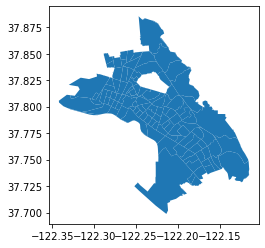

In [19]:
#map tracs_oakland to confirm
tracts_oakland_clipped.plot()

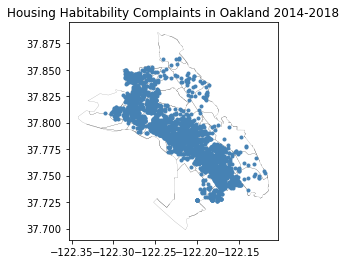

In [20]:
#create dot map with census tracts as outlines
# we use hh_gdf for the points and tracts_oakland_clipped for the background

fig, ax = plt.subplots()

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.1)

hh_gdf.plot(ax=ax, #hh_gdf is the dataframe with the point data
           marker = '.',
           color = 'steelblue')

plt.title('Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

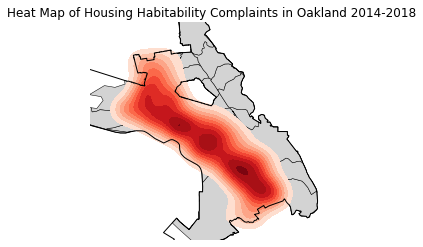

In [21]:
# Heat Map Per https://residentmario.github.io/geoplot/plot_references/plot_reference.html#kdeplot

fig, ax = plt.subplots()

tracts_oakland_clipped.plot(ax=ax,
                            color='lightgrey',
                            edgecolor='black',
                           linewidth=.5)

gplt.kdeplot(hh_gdf, #dataframe with the point data
             ax=ax,
            shade=True,
            cmap ='Reds')

oakland_bounds.plot(ax=ax,
                   color='None',
                   edgecolors='black',
                   linewidth=1)

plt.title('Heat Map of Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

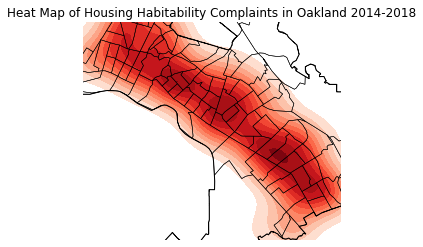

In [22]:
#note: the kernel density heat map helps show three particularly intense areas of complaints

#for future, zoom in on this bounding box of the area we care about which is not a north-south oriented rectangle 
# [-122.1912508998,37.7294442058],[-122.2912073353,37.7971420583],[-122.2585473083,37.8272596933],[-122.1585908729,37.7595894292]


fig, ax = plt.subplots()

gplt.kdeplot(hh_gdf, #dataframe with the point data
             ax=ax,
            shade=True,
            cmap ='Reds')

oakland_bounds.plot(ax=ax,
                   color='None',
                   edgecolors='black',
                   linewidth=1)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

ax.set_ylim([37.725, 37.825])
ax.set_xlim([-122.3, -122.15])
[-122.2366988928,37.7466480517],[-122.2895940006,37.8118386842],[-122.2473374041,37.8332448445],[-122.1944422963,37.7680731031]
plt.title('Heat Map of Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

In [23]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'index_right', 'Address', 'HH_Complaint',
       'Address_recode', 'latitude', 'longitude'],
      dtype='object')

In [24]:
# Create Cholopleth Map
#     a) Create data frame of census tracts, their geometry, and the sum of addresses with complaints in that tract
#     b) Run code for basic Choropleth Map
#     c) Save Chloropleth Map to out_maps folder

gdf['unique_complaints'] = 1
#creating the gdf for mapping
hh_tracts = gdf.groupby(['NAME']).sum()
hh_tracts.drop(columns=['ALAND','AWATER','index_right','latitude','longitude'],inplace=True)
hh_tracts.head()

,HH_Complaint,unique_complaints
NAME,,
4001,8,6
4002,3,3
4003,21,13
4004,30,16
4005,7,5


In [25]:
#add in the geometry from the oakland_tracts_clipped version
hh_tracts_gdf = tracts_oakland_clipped.merge(hh_tracts,on='NAME',copy=True)

In [26]:
#this is the dataframe we should use for mapping and analysis of census data
hh_tracts_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 114 entries, 0 to 113
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   STATEFP            114 non-null    object  
 1   COUNTYFP           114 non-null    object  
 2   TRACTCE            114 non-null    object  
 3   AFFGEOID           114 non-null    object  
 4   GEOID              114 non-null    object  
 5   NAME               114 non-null    object  
 6   LSAD               114 non-null    object  
 7   ALAND              114 non-null    int64   
 8   AWATER             114 non-null    int64   
 9   geometry           114 non-null    geometry
 10  HH_Complaint       114 non-null    int64   
 11  unique_complaints  114 non-null    int64   
dtypes: geometry(1), int64(4), object(7)
memory usage: 11.6+ KB


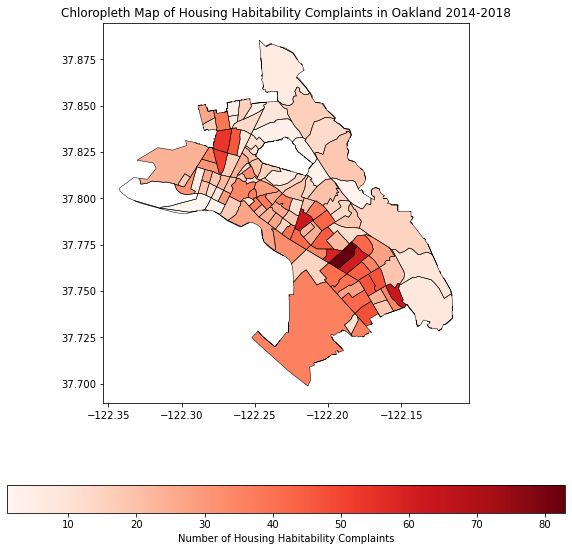

In [27]:
#cholorpleth map of complaints
fig, ax = plt.subplots(figsize = (10,10)) 
hh_tracts_gdf.plot(column='unique_complaints',
                    cmap='Reds',
                    legend=True,
                    legend_kwds={'label': "Number of Housing Habitability Complaints",
                                 'orientation': "horizontal"},
                    ax=ax)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

plt.title('Chloropleth Map of Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

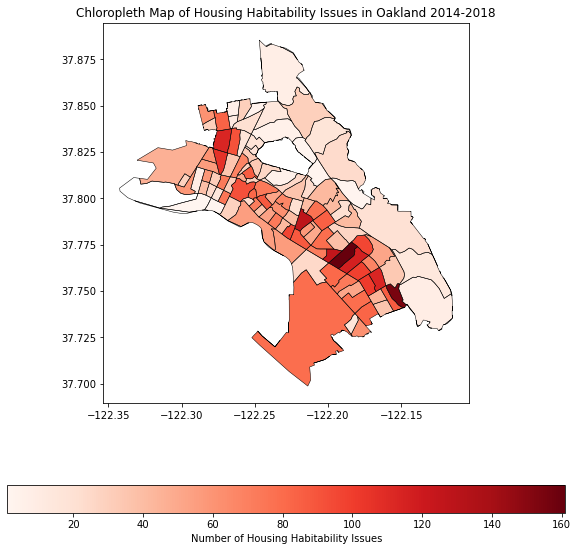

In [28]:
#cholorpleth map of housing habitability 'hits'

fig, ax = plt.subplots(figsize = (10,10)) 
hh_tracts_gdf.plot(column='HH_Complaint',
                    cmap='Reds',
                    legend=True,
                    legend_kwds={'label': "Number of Housing Habitability Issues",
                                 'orientation': "horizontal"},
                    ax=ax)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

plt.title('Chloropleth Map of Housing Habitability Issues in Oakland 2014-2018')
plt.show()
#very similar issue

In [29]:
#wondering what the relationship is between the issues and complaints, checking the pearson correlation coefficient
np.corrcoef(hh_tracts_gdf['HH_Complaint'],hh_tracts_gdf['unique_complaints'])
#answer is so highly correlated at 0.972 it doesn't really matter which one you use.

array([[1.        , 0.97229046],
       [0.97229046, 1.        ]])

In [30]:
#bringing in the Oakland police beats which are the closest thing we have to neighborhood descriptors
# and are well understood by Oakland policy makers
police_beats = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland Community Police Beats.geojson')

In [31]:
#changing the crs to be correct
police_beats.to_crs(hh_gdf.crs, inplace=True)

In [32]:
pb_columns_to_drop = ['cp_beat', 'agency', 'pol_dist',
       'response', 'id', 'pol_beat', 'fullname', 'flag', 'ruleid_1', 'message',
       'sourcethm', 'action', 'pol_sect', 'shape_len']
police_beats.drop(columns = pb_columns_to_drop,inplace=True)

In [33]:
beats_gdf = gpd.GeoDataFrame(police_beats)

In [34]:
beats_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   acres       142 non-null    object  
 1   name        142 non-null    object  
 2   shape_area  142 non-null    object  
 3   geometry    142 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 4.6+ KB


In [35]:
#creating same dataframe across police beats to show 'neighborhoods' better
#spatial join the point data with the police beat data
gpd.sjoin(hh_gdf, beats_gdf, how='right', op='within')

#note, something confusing is happening here. Why all the sudden does it have 5576 rows instead of the original 2776?

,index_left,Address,HH_Complaint,Address_recode,latitude,longitude,acres,name,shape_area,geometry
0,2142.0,"624 OAK ST, Oakland CA 94607",2.0,"624 OAK ST, Oakland, CA 94607",37.795731,-122.266119,214.241,03X,10456735.4319,"MULTIPOLYGON (((-122.26220 37.79220, -122.2623..."
0,2143.0,"627 OAK ST, Oakland CA 94607",1.0,"627 OAK ST, Oakland, CA 94607",37.795813,-122.266299,214.241,03X,10456735.4319,"MULTIPOLYGON (((-122.26220 37.79220, -122.2623..."
0,2144.0,"609 OAK ST, APT 607, Oakland CA 94607",2.0,"609 OAK ST, Oakland, CA 94607",37.795918,-122.266548,214.241,03X,10456735.4319,"MULTIPOLYGON (((-122.26220 37.79220, -122.2623..."
0,2150.0,"72 7TH ST, Oakland CA 94607",2.0,"72 7TH ST, Oakland, CA 94607",37.796064,-122.265237,214.241,03X,10456735.4319,"MULTIPOLYGON (((-122.26220 37.79220, -122.2623..."
0,2149.0,"72 7TH ST, UNIT A, Oakland CA 94607",2.0,"72 7TH ST, Oakland, CA 94607",37.796064,-122.265237,214.241,03X,10456735.4319,"MULTIPOLYGON (((-122.26220 37.79220, -122.2623..."
...,...,...,...,...,...,...,...,...,...,...
137,NaN,NaN,NaN,NaN,NaN,NaN,1101.745,PDT2,47159850.0283,"MULTIPOLYGON (((-122.22595 37.83173, -122.2257..."
138,NaN,NaN,NaN,NaN,NaN,NaN,215.606,LKM1,6139452.45852,"MULTIPOLYGON (((-122.26121 37.80680, -122.2610..."
139,NaN,NaN,NaN,NaN,NaN,NaN,295.576,31Z,51422.045956,"MULTIPOLYGON (((-122.19204 37.71398, -122.1929..."
140,NaN,NaN,NaN,NaN,NaN,NaN,2789.632,13Y,215813.536259,"MULTIPOLYGON (((-122.17495 37.86607, -122.1766..."


In [36]:
hh_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Address         2776 non-null   object  
 1   HH_Complaint    2776 non-null   int64   
 2   Address_recode  2776 non-null   object  
 3   latitude        2776 non-null   float64 
 4   longitude       2776 non-null   float64 
 5   geometry        2776 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 130.2+ KB


# Importing and Readying ACS Variables

- download csv files of tables for building age, race, tenure, occupants per room for census tracts in Oakland
- clean/prepare variables and merge into single dataframe

## Building Age Dataframe

In [37]:
#bring in table B25306
acs1_df = pd.read_csv(r'C:\Users\amarq\Python_Projects\raw_data\Alameda County Tenure by Year Structure Built_ACS 5 Year 2018.csv')

In [38]:
acs1_df.columns

Index(['id', 'Geographic Area Name', 'Estimate!!Total',
       'Margin of Error!!Total', 'Estimate!!Total!!Owner occupied',
       'Margin of Error!!Total!!Owner occupied',
       'Estimate!!Total!!Owner occupied!!Built 2014 or later',
       'Margin of Error!!Total!!Owner occupied!!Built 2014 or later',
       'Estimate!!Total!!Owner occupied!!Built 2010 to 2013',
       'Margin of Error!!Total!!Owner occupied!!Built 2010 to 2013',
       'Estimate!!Total!!Owner occupied!!Built 2000 to 2009',
       'Margin of Error!!Total!!Owner occupied!!Built 2000 to 2009',
       'Estimate!!Total!!Owner occupied!!Built 1990 to 1999',
       'Margin of Error!!Total!!Owner occupied!!Built 1990 to 1999',
       'Estimate!!Total!!Owner occupied!!Built 1980 to 1989',
       'Margin of Error!!Total!!Owner occupied!!Built 1980 to 1989',
       'Estimate!!Total!!Owner occupied!!Built 1970 to 1979',
       'Margin of Error!!Total!!Owner occupied!!Built 1970 to 1979',
       'Estimate!!Total!!Owner occupied

In [39]:
#rename the columns that we need with c_built_*years*
renamings1 = {'Estimate!!Total': 'c_households',
            'Estimate!!Total!!Owner occupied': 'c_owner_households',
            'Estimate!!Total!!Renter occupied':'c_renter_households',
             'Margin of Error!!Total':'moe_households'}

acs1_df.rename(columns = renamings1, inplace=True)
# def rename_column(column):
# """ pass the name of a column through this function and it renames it in acs1_df
#     using the c_'some name' convention"""
#     if 'renter' in column:
#         return print(column 'not renamed')
#     elif 'Margin of Error' in column:
#         return print(column 'not renamed')
#     else:
#         acs1_df.rename(columns= {columns}
# years = [2014, 2010, 2000, 1990, 1980, 1970, 1960, 1950, 1940, 1939]
# renamings2 = {}
# for year in years:
#     for i in acs1_df.columns:
#         acs1_df[]

In [40]:
acs1_df.columns[6].rsplit('!!',1)[1]

'Built 2014 or later'

In [41]:
#renaming the columns with all the stuff in them so it's a litle more readable
# initialize a dictionary where the keys are the column names and the values are a prettier verison, just for renters
renamings2 = {}
for i in acs1_df.columns:
    if 'Renter' in i:
        if 'Margin' in i:
            renamings2[i] = 'moe_renter_' + i.rsplit('!!',1)[1]
        else:
            renamings2[i] = 'c_renter_' + i.rsplit('!!',1)[1]


In [42]:
#use this dictionary to rename the columns to a more readable fashion
acs1_df.rename(columns= renamings2,inplace=True)

In [43]:
#drop all the columns we don't need
#first use list comprehension to create a list of column names we don't want
c_todrop = [i for i in acs1_df.columns if 'Owner' in i]

In [44]:
acs1_df.drop(columns=c_todrop,inplace=True)

In [45]:
#this is the building ages for renters for each census tract in Alameda County
acs1_df.columns

Index(['id', 'Geographic Area Name', 'c_households', 'moe_households',
       'c_owner_households', 'c_renter_households',
       'moe_renter_Renter occupied', 'c_renter_Built 2014 or later',
       'moe_renter_Built 2014 or later', 'c_renter_Built 2010 to 2013',
       'moe_renter_Built 2010 to 2013', 'c_renter_Built 2000 to 2009',
       'moe_renter_Built 2000 to 2009', 'c_renter_Built 1990 to 1999',
       'moe_renter_Built 1990 to 1999', 'c_renter_Built 1980 to 1989',
       'moe_renter_Built 1980 to 1989', 'c_renter_Built 1970 to 1979',
       'moe_renter_Built 1970 to 1979', 'c_renter_Built 1960 to 1969',
       'moe_renter_Built 1960 to 1969', 'c_renter_Built 1950 to 1959',
       'moe_renter_Built 1950 to 1959', 'c_renter_Built 1940 to 1949',
       'moe_renter_Built 1940 to 1949', 'c_renter_Built 1939 or earlier',
       'moe_renter_Built 1939 or earlier'],
      dtype='object')

In [46]:
acs1_df['p_renter_pre1939'] = acs1_df['c_renter_Built 1939 or earlier'] /  acs1_df['c_renter_households'] 

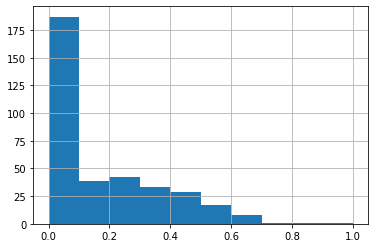

In [47]:
acs1_df['p_renter_pre1939'].hist()

In [48]:
#we merge the tracts_gdf with our ACS data using an attribute join with id in acs1_df and AFFGEOID in tracts_gdf
# first rename id to AFFGEOID in acs1_df

acs1_df.rename(columns={'id':'AFFGEOID'},inplace=True)

#second, merge the acs data with the CA tracts data
acs1_gdf = tracts_gdf.merge(acs1_df, on='AFFGEOID')

In [49]:
acs1_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'Geographic Area Name', 'c_households',
       'moe_households', 'c_owner_households', 'c_renter_households',
       'moe_renter_Renter occupied', 'c_renter_Built 2014 or later',
       'moe_renter_Built 2014 or later', 'c_renter_Built 2010 to 2013',
       'moe_renter_Built 2010 to 2013', 'c_renter_Built 2000 to 2009',
       'moe_renter_Built 2000 to 2009', 'c_renter_Built 1990 to 1999',
       'moe_renter_Built 1990 to 1999', 'c_renter_Built 1980 to 1989',
       'moe_renter_Built 1980 to 1989', 'c_renter_Built 1970 to 1979',
       'moe_renter_Built 1970 to 1979', 'c_renter_Built 1960 to 1969',
       'moe_renter_Built 1960 to 1969', 'c_renter_Built 1950 to 1959',
       'moe_renter_Built 1950 to 1959', 'c_renter_Built 1940 to 1949',
       'moe_renter_Built 1940 to 1949', 'c_renter_Built 1939 or earlier',
       'moe_renter_Built 1939 or earlier', 'p_renter_pre1939']

In [50]:
#third, clip the tracts to the City of Oakland boundary, this removes all the other california tracts.
# area interpolation not needed as all Oakland census tracts fit nicely into the city

acs1_oakland_gdf = gpd.clip(acs1_gdf, oakland_bounds).reset_index(drop=True)

#this it the data frame we should use for mapping renter density, old age building density

In [51]:
#check make sure it isn't crazy
acs1_oakland_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   STATEFP                           140 non-null    object  
 1   COUNTYFP                          140 non-null    object  
 2   TRACTCE                           140 non-null    object  
 3   AFFGEOID                          140 non-null    object  
 4   GEOID                             140 non-null    object  
 5   NAME                              140 non-null    object  
 6   LSAD                              140 non-null    object  
 7   ALAND                             140 non-null    int64   
 8   AWATER                            140 non-null    int64   
 9   geometry                          140 non-null    geometry
 10  Geographic Area Name              140 non-null    object  
 11  c_households                      140 non-null    

##  Income ACS Data

In [57]:
#bring in table DP04
acs2_df = pd.read_csv(r'C:\Users\amarq\Python_Projects\raw_data\Alameda County Median Household Income by Tenure_ACS 5 Year 2018.csv')

In [58]:
acs2_df.columns

Index(['GEO_ID', 'Geographic Area Name',
       'Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Total',
       'Margin of Error!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Total',
       'Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Owner occupied (dollars)',
       'Margin of Error!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Owner occupied (dollars)',
       'Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Renter occupied (dollars)',
       'Margin of Error!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Renter occupied (dollars)'],
      dtype='object')

In [63]:
#rename the column we need to be useful
renaming = {'Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Renter occupied (dollars)':
           'median_income_renter_hh'}

acs2_df.rename(columns=renaming, inplace=True)

#droping all the other ones so we just have the good one
acs2_df.drop(columns= ['Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Total',
       'Margin of Error!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Total',
       'Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Owner occupied (dollars)',
       'Margin of Error!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Owner occupied (dollars)',
       'Margin of Error!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars) --!!Renter occupied (dollars)'],
            inplace=True)


In [76]:
#then we merge the tracts_gdf with our ACS data using an attribute join with id in acs2_df and AFFGEOID in tracts_gdf
# first rename id to AFFGEOID in acs1_df

acs2_df.rename(columns={'GEO_ID':'AFFGEOID'},inplace=True)

In [84]:
#second, merge the acs data with our previous geodataframe that's already clipped to Oakland
acs2_oakland_gdf = acs1_oakland_gdf.merge(acs2_df, on='AFFGEOID')

#drop the old geographic area name
acs2_oakland_gdf.drop(columns='Geographic Area Name_y',inplace=True)

In [139]:
acs2_oakland_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   STATEFP                           140 non-null    object  
 1   COUNTYFP                          140 non-null    object  
 2   TRACTCE                           140 non-null    object  
 3   AFFGEOID                          140 non-null    object  
 4   GEOID                             140 non-null    object  
 5   NAME                              140 non-null    object  
 6   LSAD                              140 non-null    object  
 7   ALAND                             140 non-null    int64   
 8   AWATER                            140 non-null    int64   
 9   geometry                          140 non-null    geometry
 10  Geographic Area Name_x            140 non-null    object  
 11  c_households                      140 non-null    

In [151]:
#median_income is an object, shoud be a float/interger
#changing the -'s to none's first
acs2_oakland_gdf['median_income_renter_hh'].replace('-',None,inplace=True)

In [157]:
#changing the type to a flat
acs2_oakland_gdf = acs2_oakland_gdf.astype({'median_income_renter_hh': int})

In [158]:
acs2_oakland_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   STATEFP                           140 non-null    object  
 1   COUNTYFP                          140 non-null    object  
 2   TRACTCE                           140 non-null    object  
 3   AFFGEOID                          140 non-null    object  
 4   GEOID                             140 non-null    object  
 5   NAME                              140 non-null    object  
 6   LSAD                              140 non-null    object  
 7   ALAND                             140 non-null    int64   
 8   AWATER                            140 non-null    int64   
 9   geometry                          140 non-null    geometry
 10  Geographic Area Name_x            140 non-null    object  
 11  c_households                      140 non-null    

##### Race Data

Bringing in data set on racial makeup of Alameda County, by Census Tract. 


In [5]:
#bring in data table B02001 from ACS 5 year 2018.

acs1_df = pd.read_csv(r'C:\Users\eishii\Documents\Data for Housing Class Data\RACE-ALAMEDACOUNTYBYTRACT.csv')


In [6]:
acs1_df.columns

Index(['id', 'Geographic Area Name', 'Estimate  Total',
       'Margin of Error  Total', 'Estimate  Total  White alone',
       'Margin of Error  Total  White alone',
       'Estimate  Total  Black or African American alone',
       'Margin of Error  Total  Black or African American alone',
       'Estimate  Total  American Indian and Alaska Native alone',
       'Margin of Error  Total  American Indian and Alaska Native alone',
       'Estimate  Total  Asian alone', 'Margin of Error  Total  Asian alone',
       'Estimate  Total  Native Hawaiian and Other Pacific Islander alone',
       'Margin of Error  Total  Native Hawaiian and Other Pacific Islander alone',
       'Estimate  Total  Some other race alone',
       'Margin of Error  Total  Some other race alone',
       'Estimate  Total  Two or more races',
       'Margin of Error  Total  Two or more races',
       'Estimate  Total  Two or more races  Two races including Some other race',
       'Margin of Error  Total  Two or more ra

# Mapping ACS Data to Compare to HH Complaints

Here, we map a few variables by census tract to compare them to the distribution of housing habitability complaints
We also calculate the correlation coefficient between the each variable as housing habitability complaints to better understand
the relationship.

### We map the following 

- number of renters
- percentage of renters in homes built before 1939
- median household income of renters
- concentration of racial/ethnic minorities (Black, Hispanic)

## Number of renters

Creating a map of the number of renter households using acs1_oakland_gdf

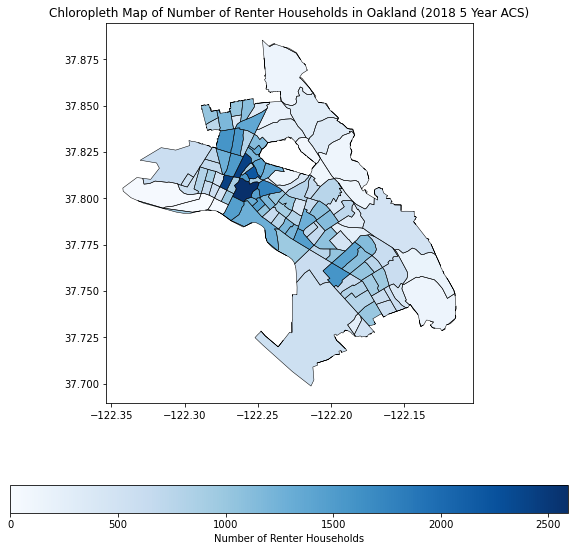

In [87]:
#cholorpleth map of number of renters
fig, ax = plt.subplots(figsize = (10,10)) 
acs1_oakland_gdf.plot(column='c_renter_households',
                    cmap='Blues',
                    legend=True,
                    legend_kwds={'label': "Number of Renter Households",
                                 'orientation': "horizontal"},
                    ax=ax)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

plt.title(r'Chloropleth Map of Number of Renter Households in Oakland (2018 5 Year ACS)')
plt.show()

In [97]:
# want to create ow calculating the correlation between the two variables
#first time I tried this, I realized that HH Complaints don't exist in all census tracts... so need those to be dropped
#also need to double check that the census tracts are correctly ordered
# np.corrcoef(hh_tracts_gdf['HH_Complaint'],acs1_oakland_gdf['c_renter_households'])

## Percentage of Renters in Homes Built Before 1939

Creating a map of the number of renter households using acs1_oakland_gdf

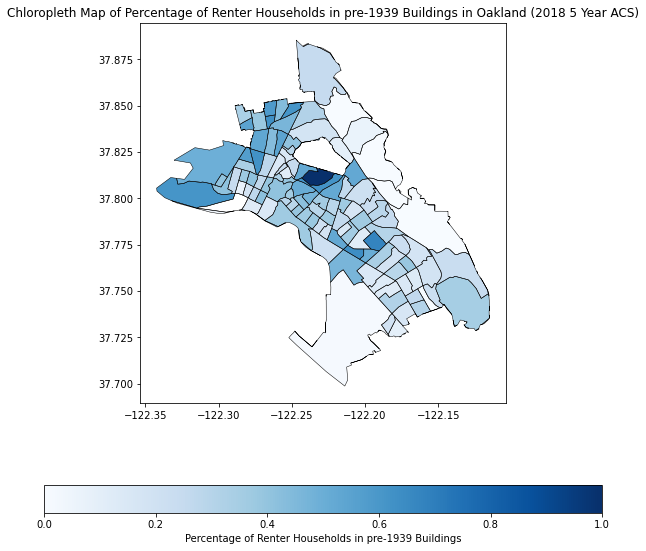

In [88]:
#cholorpleth map of number of renters
fig, ax = plt.subplots(figsize = (10,10)) 
acs1_oakland_gdf.plot(column='p_renter_pre1939',
                    cmap='Blues',
                    legend=True,
                    legend_kwds={'label': "Percentage of Renter Households in pre-1939 Buildings",
                                 'orientation': "horizontal"},
                    ax=ax)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

plt.title(r'Chloropleth Map of Percentage of Renter Households in pre-1939 Buildings in Oakland (2018 5 Year ACS)')
plt.show()

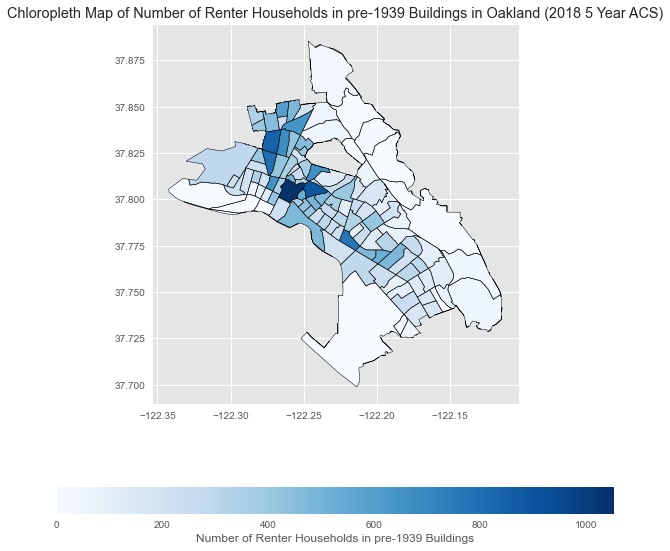

In [128]:
#cholorpleth map of number of renters in pre-1939
with plt.style.context(("seaborn", "ggplot")): #decided to check out this style of map - it's ok
    fig, ax = plt.subplots(figsize = (10,10)) 
    acs1_oakland_gdf.plot(column='c_renter_Built 1939 or earlier',
                        cmap='Blues',
                        legend=True,
                        legend_kwds={'label': "Number of Renter Households in pre-1939 Buildings",
                                     'orientation': "horizontal"},
                        ax=ax)

    tracts_oakland_clipped.plot(ax=ax,
                                color='None',
                                edgecolor='black',
                               linewidth=.5)

    plt.title(r'Chloropleth Map of Number of Renter Households in pre-1939 Buildings in Oakland (2018 5 Year ACS)')
    plt.show()

In [161]:
# now calculating the correlation between the two variables we just mapped
np.corrcoef(acs1_oakland_gdf['p_renter_pre1939'],acs1_oakland_gdf['c_renter_Built 1939 or earlier'])

#something is now strange here, it used to be .5 or so

array([[nan, nan],
       [nan,  1.]])

## Median Household Income for Renters

Creating a map of the number of renter households using acs2_oakland_gdf.median_income_renter_hh

In [114]:
acs2_oakland_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   STATEFP                           140 non-null    object  
 1   COUNTYFP                          140 non-null    object  
 2   TRACTCE                           140 non-null    object  
 3   AFFGEOID                          140 non-null    object  
 4   GEOID                             140 non-null    object  
 5   NAME                              140 non-null    object  
 6   LSAD                              140 non-null    object  
 7   ALAND                             140 non-null    int64   
 8   AWATER                            140 non-null    int64   
 9   geometry                          140 non-null    geometry
 10  Geographic Area Name_x            140 non-null    object  
 11  c_households                      140 non-null    

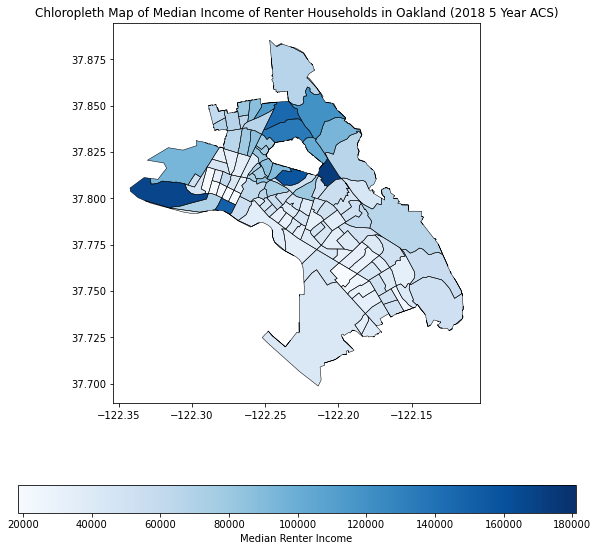

In [160]:
#cholorpleth map of median renter income in pre-1939
fig, ax = plt.subplots(figsize = (10,10)) 
acs2_oakland_gdf.plot(column='median_income_renter_hh',
                      cmap='Blues',
                      legend=True,
                        legend_kwds={'label': "Median Renter Income",
                                     'orientation': "horizontal"},
                      ax=ax)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

plt.title(r'Chloropleth Map of Median Income of Renter Households in Oakland (2018 5 Year ACS)')
plt.show()

## Calculating Correlations

between number of hh complaints and 1) pre-1939 buildings 2) median income

In [168]:
#now calculating the correlation between the median income and the number of hh complaints

#first, join in the hh complaints
acs2_withHH = hh_tracts_gdf.merge(acs2_oakland_gdf, on='AFFGEOID')
acs2_withHH.columns

Index(['STATEFP_x', 'COUNTYFP_x', 'TRACTCE_x', 'AFFGEOID', 'GEOID_x', 'NAME_x',
       'LSAD_x', 'ALAND_x', 'AWATER_x', 'geometry_x', 'HH_Complaint',
       'unique_complaints', 'STATEFP_y', 'COUNTYFP_y', 'TRACTCE_y', 'GEOID_y',
       'NAME_y', 'LSAD_y', 'ALAND_y', 'AWATER_y', 'geometry_y',
       'Geographic Area Name_x', 'c_households', 'moe_households',
       'c_owner_households', 'c_renter_households',
       'moe_renter_Renter occupied', 'c_renter_Built 2014 or later',
       'moe_renter_Built 2014 or later', 'c_renter_Built 2010 to 2013',
       'moe_renter_Built 2010 to 2013', 'c_renter_Built 2000 to 2009',
       'moe_renter_Built 2000 to 2009', 'c_renter_Built 1990 to 1999',
       'moe_renter_Built 1990 to 1999', 'c_renter_Built 1980 to 1989',
       'moe_renter_Built 1980 to 1989', 'c_renter_Built 1970 to 1979',
       'moe_renter_Built 1970 to 1979', 'c_renter_Built 1960 to 1969',
       'moe_renter_Built 1960 to 1969', 'c_renter_Built 1950 to 1959',
       'moe_renter_Bu

In [170]:
np.corrcoef(acs2_withHH['median_income_renter_hh'],acs2_withHH['HH_Complaint'])

array([[ 1.        , -0.46669868],
       [-0.46669868,  1.        ]])

In [171]:
np.corrcoef(acs2_withHH['c_renter_Built 1939 or earlier'],acs2_withHH['HH_Complaint'])

array([[1.        , 0.36990456],
       [0.36990456, 1.        ]])

In [173]:
#the directions are as expected. Hard to think about the strength though. Seems like only a weak to medium strength
#correlation 
lr = LinearRegression()
lr.fit(acs2_withHH['median_income_renter_hh'], acs2_withHH['HH_Complaint'])

ValueError: Expected 2D array, got 1D array instead:
array=[ 64643  69323  33445  19905  19905  85571  74122  34595  45180  70208
  70208  50625  22031  59938  74167  78932  51913  64462  30103  34471
  45856  39236  36250  38125  26367  79539  43699  46543  47273  35100
  87396  79298  40665  50083  45875 150673  31667  49120  37629  96000
 113897  66774  66774  66991  59773  86500  34856  95139  19720  61924
  71458 145938  94167  50370  54688  31809  34615  43393  44500  44500
  43892  32467  42466  31268  19570  45383 119632  37925  72558  81448
 134929  51341  46037  36383  38719  59861  40313  34125  50781  40278
  50417 102000  79625 157083  48158  28675  25391  51250  39857  36371
  40108  52168  52168  65435  30313  86786 173750  48250  18387  55469
  41250  66184  66184  30669  32015  56406  32051  90478  33333  50823
  45042  75262  52045  41723].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.